#### &nbsp;
# **Twitter Sentiment Analysis**
#### Author: &nbsp; Ankit S Kumar
#### &nbsp;

## Project Description
In the era of digital communication, social media platforms like Twitter have become pivotal for individuals and organisations to express opinions, share news, and engage with communities. With millions of tweets generated daily, Twitter provides a rich source of data that can be analysed to gauge public sentiment on various topics. Twitter sentiment analysis leverages Natural Language Processing (NLP) and machine learning techniques to identify and classify the sentiment behind tweets, categorising them as positive, negative, or neutral. 

In this project, we train classification models from Scikit-Learn library to perform Twitter Sentiment Analysis and categorise the general sentiment of tweets as either positive or negative. This project demonstrates different elements of text processing, feature extraction, and model training and evaluation. Throughout the project, the Python programming language is utilised. 

## Objectives
- To preprocess and clean tweet text data.
- To convert textual data into numerical features using TF-IDF vectorization.
- To train machine learning models to classify the sentiment of tweets.
- To evaluate and compare the model's performance using appropriate metrics like weighted F1-score.
- To improve the model's performance using hyperparameter tuning.

## Project Workflow

### 1. Import libraries
Import necessary libraries for data handling, preprocessing, and model building.
- *Pandas*: For data manipulation and analysis.
- *NumPy*: For numerical computations.
- *NLTK* and *Re*: For text preprocessing and tokenization.
- *Scikit-Learn*: For machine learning algorithms and feature extraction.
- *Matplotlib* and *Seaborn*: For data visualisation

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk, re
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from sklearn.naive_bayes import MultinomialNB


### 2. Import the Twitter dataset
The Twitter dataset is loaded from the nltk repository. It consists of two lists (containing tweets as string datatype), each named with the corresponding sentiment -- positive or negative. After importing the dataset, tweets are labelled as 1 for positive and 0 for negative. Finally, the dataset is converted into Pandas dataframe for efficient data processing.

In [2]:
# Loading twitter data (lists) from nltk
nltk.download('twitter_samples')
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
tweets = positive_tweets + negative_tweets
label = np.zeros(len(tweets),dtype='int8')
label[:len(positive_tweets)] = 1

# Converting lists to Pandas Dataframes
tweets_df = pd.DataFrame([label, tweets], index=['label', 'tweet']).T
tweets_df['label'] = tweets_df['label'].astype('int8')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


### 3. Exploratory data analysis

After collecting the Twitter dataset, the next crucial step is to perform Exploratory Data Analysis (EDA). EDA helps in understanding the dataset and gaining insights that may inform further preprocessing and modelling steps.

##### a) Check dataset structure:

In [3]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int8  
 1   tweet   10000 non-null  object
dtypes: int8(1), object(1)
memory usage: 88.0+ KB


In [4]:
tweets_df.head()

,label,tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,1,@Lamb2ja Hey James! How odd :/ Please call our...
2,1,@DespiteOfficial we had a listen last night :)...
3,1,@97sides CONGRATS :)
4,1,yeaaaah yippppy!!! my accnt verified rqst has...


##### b) Remove rows with empty and duplicate tweets:
The dataset is checked for rows with missing values and duplicates. Addressing these issues ensures the data's integrity and quality.

In [5]:
#Checking for white spaces and null cells
tweets_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
tweets_df.isnull().sum()

#rows_with_nulls = df[df.isnull().any(axis=1)]

label    0
tweet    0
dtype: int64

In [6]:
#Checking for duplicate tweets
tweets_df['tweet'].duplicated().sum()

0

##### c) Explore sentiment distribution and tweet length statistics:
Sentiment distribution and descriptive statistics for tweet lengths are calculated. This reveals if there's a significant difference in tweet lengths between the two sentiments. In some projects, this information could be used as an interesting feature for the model.

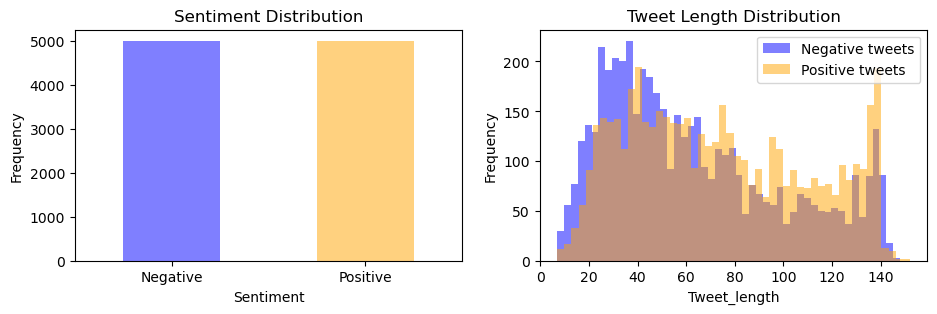

In [7]:
# Get the length of the tweets
tweets_df['tweet_length'] = tweets_df['tweet'].apply(len)

# Visualize the distribution of sentiments
plt.figure(figsize=(11,3))
plt.rcParams.update({'font.size': 10})
plt.subplot(121)
tweets_df['label'].value_counts().plot(kind='bar', alpha=0.5, color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'],rotation=0)

plt.subplot(122)
#Plotting the histogram of tweet lengths
pos_tweet_len = tweets_df[tweets_df['label']==1]['tweet_length']
neg_tweet_len = tweets_df[tweets_df['label']==0]['tweet_length']
neg_tweet_len.plot(kind='hist', alpha=0.5, label='Negative tweets', bins=50,color='blue')
pos_tweet_len.plot(kind='hist', alpha=0.5, label='Positive tweets', bins=50, color='orange')
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet_length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [8]:
tweet_stats = pd.concat([pos_tweet_len.describe(), neg_tweet_len.describe()], axis=1)
tweet_stats.columns = ['Positive tweets', 'Negative tweets']
tweet_stats

,Positive tweets,Negative tweets
count,5000.000000,5000.000000
mean,73.688200,63.387200
std,36.858539,36.704069
min,7.000000,7.000000
25%,42.000000,34.000000
50%,69.000000,54.000000
75%,103.000000,88.000000
max,152.000000,148.000000


**Verdict**: The Twitter dataset is balanced and has an equal number of positive and negative tweets, with 5000 tweets in each class. On average, positive tweets are longer than negative tweets. The mean length of positive tweets is approximately 10 characters higher than that of negative tweets.

### 4. Data Preprocessing
Data preprocessing is an important step in the workflow of NLP projects like sentiment analysis. It involves transforming raw/unstructured text data into a clean and structured format that improves the accuracy and efficiency of machine learning models. In the current dataset, each tweet is preprocessed by employing a pipeline that performs the following functions:
- *Cleaning*: Convert text to lowercase and remove URLs, mentions, hashtags, punctuation, etc.
- *Tokenization*: Split the text into individual words (tokens) to perform stopword removal and stemming.
- *Stopword Removal*: Remove common words that do not contribute much to the sentiment (e.g., "the", "is", "and").
- *Stemming*: Convert words to their base forms that reduces the number of unique words in the dataset. (e.g., "connect," "connected," "connecting," and "connection" can all be reduced to "connect")

In [9]:
# Defining function to preprocess tweets

rx_tick = re.compile(r'\$\w*') # remove stock market tickers like $GE
rx_handle = re.compile(r'\@\w*') # remove handles like @user
rx_RT = re.compile(r'^RT[\s]+')# remove old style retweet text "RT"
rx_hyp = re.compile(r'https?://[^\s\n\r]+') # remove hyperlinks
rx_hash = re.compile(r'#') #removing the hash # sign from the hashtag
rx_alpha = re.compile(r'[^A-Za-z0-9 ]+') #only retain alphabets and numbers

nltk_tokenize = TweetTokenizer(reduce_len=True).tokenize #Tokenization
nltk.download('stopwords')
stop_words = set(stopwords.words('english') +['im'] ) #Stopword removal including "I'm".
nltk_stem = SnowballStemmer(language='english').stem #Stemming

def tweet_preprocess_pipeline(tweet):

    tweet = tweet.lower()
    tweet = rx_tick.sub('',tweet)
    tweet = rx_handle.sub('',tweet)
    tweet = rx_RT.sub('',tweet)
    tweet = rx_hyp.sub('',tweet)
    tweet = rx_hash.sub('',tweet)
    tweet = rx_alpha.sub('',tweet)
    tokens = nltk_tokenize(tweet)
    tokens = [nltk_stem(w) for w in tokens if w not in stop_words and len(w)>1]
    tweet = ' '.join(tokens) 
    
    return tweet


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Preprocess tweets using a pipeline
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(tweet_preprocess_pipeline)

#Removing rows with empty "cleaned_tweet" column
tweets_df = tweets_df[tweets_df['cleaned_tweet'].apply(lambda x: x.strip() != '')]
tweets_df.reset_index(drop=True, inplace=True)

tweets_df

,label,tweet,tweet_length,cleaned_tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...,111,followfriday top engag member communiti week
1,1,@Lamb2ja Hey James! How odd :/ Please call our...,126,hey jame odd pleas call contact centr 02392441...
2,1,@DespiteOfficial we had a listen last night :)...,107,listen last night bleed amaz track scotland
3,1,@97sides CONGRATS :),20,congrat
4,1,yeaaaah yippppy!!! my accnt verified rqst has...,106,yeaaah yipppi accnt verifi rqst succeed got bl...
...,...,...,...,...
9915,0,I wanna change my avi but uSanele :(,36,wanna chang avi usanel
9916,0,MY PUPPY BROKE HER FOOT :(,26,puppi broke foot
9917,0,where's all the jaebum baby pictures :((,40,where jaebum babi pictur
9918,0,But but Mr Ahmad Maslan cooks too :( https://t...,60,mr ahmad maslan cook


**Verdict**: Each tweet is preprocessed and saved in the column named 'cleaned_tweet' of the dataframe. It is observed that the complexity of the tweet is significantly reduced. This step ensures that the text data is now available in a format suitable for extracting meaningful features, ultimately leading to more accurate and reliable prediction of sentiments.

#### Word cloud
Word clouds are a powerful visualisation tool that displays the most frequently occurring words in a text corpus. The size of each word in the cloud indicates its frequency or importance, making it easy to identify the dominant themes and keywords in the text.

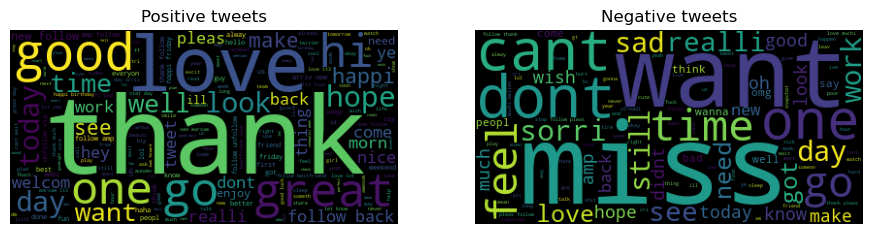

In [11]:
pos_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==1]['cleaned_tweet'])
neg_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==0]['cleaned_tweet'])

plt.figure(figsize=(11,3))
plt.rcParams.update({'font.size': 10})
plt.subplot(121)
plt.imshow(WordCloud().generate(pos_tweet_cleaned))
plt.title('Positive tweets')
plt.axis('off')
plt.subplot(122)
plt.title('Negative tweets')
plt.imshow(WordCloud().generate(neg_tweet_cleaned))
plt.axis('off')
plt.show()

**Verdict**: The word cloud for positive tweets shows words linked to positive sentiments and emotions, such as thank, love, good, and hope. On the other hand, the word cloud for negative tweets displays words, such as miss, can't, want, don't, and sad. The size of these words indicates their frequency, suggesting that these terms are prominently used in positive or negative tweets.

### 5. Feature extraction
Feature extraction in NLP involves transforming raw text data into numerical representations that can be effectively utilised by machine learning algorithms. In this project, we use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer for feature extraction. TF-IDF normalises the word frequency by their importance in the corpus and generally provides better performance than the Count vectorizer technique for text classification and information retrieval problems. 

In [12]:
#Splitting data into train set (60%), cross-validation set (20%) and test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(tweets_df['cleaned_tweet'], tweets_df['label'], test_size=0.2, stratify=tweets_df['label'])
X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)


In [13]:
#Feature extraction using TfidfVectorizer for training and test data
max_features = 5000
vectorizer = TfidfVectorizer(max_features=max_features)
X_train_tfidf = vectorizer.fit_transform(X_train) #The fit_transform method learns from the training data and then transforms it.
X_cv_tfidf = vectorizer.transform(X_cv) #Transform applies the learned transformation to the cross-validation data.
X_test_tfidf = vectorizer.transform(X_test) #Transform applies the learned transformation to the test data.


### 6. Model training and prediction
During model training, the ML algorithm learns to map input features (X) to output labels (y). In this project, we consider the following three classification models:
 - *Naive Bayes (NB)*: This classifier is based on Bayes' Theorem and the "naive" assumption that all features (or words) are independent of each other for a given class label.
 - *Logistic Regression (LR)*: This is a binary classifier that calculates the probability of the target variable belonging to a class (positive or negative) based on the linear combination of input features and a logistic function (sigmoid).
 - *Gradient Boosting (GB)*: This is an ensemble technique that builds models sequentially with each new model correcting the errors of the previous ones using gradient descent iteration.

In [14]:
#Naive Bayes classifier
model_NB = MultinomialNB()
model_NB.fit(X_train_tfidf, y_train)
y_cv_pred_NB = model_NB.predict(X_cv_tfidf)

In [15]:
#Logistic regression classifier
model_LR = LogisticRegression()
model_LR.fit(X_train_tfidf, y_train)
y_cv_pred_LR = model_LR.predict(X_cv_tfidf)

In [16]:
#Gradient boosting classifier
model_GB = GradientBoostingClassifier()
model_GB.fit(X_train_tfidf, y_train)
y_cv_pred_GB = model_GB.predict(X_cv_tfidf)

### 7. Model evaluation and selection
We evaluate the performance of the trained models using metrics such as *accuracy*, *precision*, *recall*, and *F1-score* (weighted average).

In [17]:
def get_model_eval_report(classification_reports):
    model_eval_data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score']}
    for key in classification_reports:
        report = classification_reports[key]
        model_eval_data[key] = np.array([report['accuracy'], report['weighted avg']['precision'], 
                                report['weighted avg']['recall'], report['weighted avg']['f1-score']]).round(3)
    
    return pd.DataFrame(model_eval_data)

# Construct the classification reports
report_NB = classification_report(y_cv, y_cv_pred_NB, output_dict=True)
report_LR = classification_report(y_cv, y_cv_pred_LR, output_dict=True)
report_GB = classification_report(y_cv, y_cv_pred_GB, output_dict=True)
classification_reports = {  'Naive Bayes': report_NB,
                            'Logistic Regression': report_LR,
                            'Gradient Boosting': report_GB,
                         }

model_eval_report = get_model_eval_report(classification_reports)
model_eval_report


,Metric,Naive Bayes,Logistic Regression,Gradient Boosting
0,Accuracy,0.739,0.741,0.690
1,Precision,0.739,0.743,0.726
2,Recall,0.739,0.741,0.690
3,F1-Score,0.739,0.741,0.677


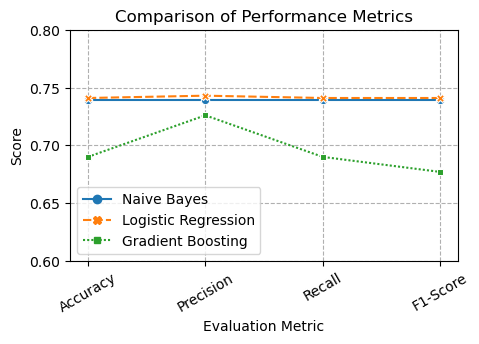

In [18]:

def plot_model_eval_report(model_eval_report, ylim):

    report_melted = model_eval_report.melt(id_vars='Metric', var_name='Model', value_name='Score')

    plt.figure(figsize=(5, 3))
    plt.rcParams.update({'font.size': 10})
    sns.lineplot(x='Metric', y='Score', hue='Model', style='Model', markers=True, data=report_melted)
    plt.title('Comparison of Performance Metrics')
    plt.xticks(rotation=30)
    plt.ylim(*ylim)
    plt.ylabel('Score')
    plt.xlabel('Evaluation Metric')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.show()

plot_model_eval_report(model_eval_report, [0.6, 0.8])

**Verdict**: Based on the evaluation metrics, Naive Bayes and Logistic Regression perform relatively better. Gradient Boosting shows a lower overall performance, particularly in terms of accuracy and F1-score, suggesting that it may not be the best choice for the present analysis.

We now explore the Logistic Regression model and attempt to improve its performance by tuning the hyperparameters. This process can be repeated for the Naive Bayes model as well.

### 7. Hyperparameter tuning
Hyperparameter tuning is performed using the GridSearchCV function that trains the model and evaluates performance metrics for each combination of hyperparameters using cross-validation. 

We set the performance metric as the *weighted F1-score* that can handle the imbalance/skewness of the dataset. However, since the Twitter dataset is nearly balanced, the *accuracy* parameter can also be chosen. For a logistic regression model, the following hyperparameters can be tuned:
- *C*: Inverse of regularisation strength; smaller values specify stronger regularization.
- *solver*: Algorithm to use in the optimisation problem; affects the convergence behaviour.
- *class_weight*: Weights associated with classes 0 or 1; useful when dealing with imbalanced datasets.

In this project, we only tune the regularisation parameter C, which is essential for preventing overfitting and improving the generalisation and interpretability of the model. We may also tune the *solver* and *class_weight* hyperparameters to improve the convergence behaviour and address the class imbalance. However, these issues are not deemed critical in this study, and hence, these hyperparameters are set to default.

In [19]:
# Define the Logistic Regression model
model_LR_temp = LogisticRegression()

# Define the hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 10, 50, 100],
#    'solver': ['liblinear', 'saga'],
#    'class_weight': ['balanced', None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model_LR_temp, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_weighted', n_jobs=-1)

# Fit the GridSearchCV object
vectorizer = TfidfVectorizer(max_features=max_features)
X_temp_tfidf = vectorizer.fit_transform(X_temp) #We use the temp dataset, which contains both the training and cross-validation sets.
grid_search.fit(X_temp_tfidf, y_temp)

# Get the best parameters and best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best F1 Score: {best_f1_score}')


Best Parameters: {'C': 2.5}
Best F1 Score: 0.7499461891047495


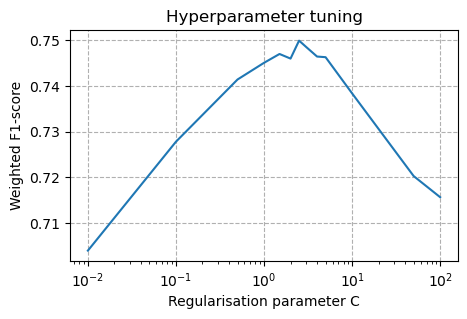

In [20]:

plt.figure(figsize=(5, 3))
plt.rcParams.update({'font.size': 10})
plt.semilogx(param_grid['C'],grid_search.cv_results_['mean_test_score'])
plt.title('Hyperparameter tuning')
plt.ylabel('Weighted F1-score')
plt.xlabel('Regularisation parameter C')
plt.grid(True, linestyle='--')

plt.show()

**Verdict**: The default value of the regularization parameter (C) is 1.0. It is very close to the optimal value with the highest *weighted F1-score*. Therefore, the improvement in the model performance is likely to be negligible.

### 8. Threshold adjustment
Threshold adjustment is often needed in classification tasks to control the trade-off between precision and recall and optimise the model's performance with respect to class imbalance in datasets and calibration issues. The LogisticRegression function in scikit-learn has a fixed threshold value of 0.5 and does not provide a direct provision to change this value. However, we can manually adjust the threshold value for making predictions after training the model.

In [21]:
# Define the Logistic Regression model with optimal hyperparameters
model_LR_final = LogisticRegression(**best_params)
model_LR_final.fit(X_train_tfidf, y_train)

# Predict probabilities on the cross-validation set to adjust threshold
y_cv_prob = model_LR_final.predict_proba(X_cv_tfidf)[:, 1]

#Specifying the range of threshold values
thresholds = np.linspace(0,1,len(y_cv_prob))

# Calculate weighted F1-score for each threshold
weighted_f1_scores = []
for threshold in thresholds:
    y_cv_pred = (y_cv_prob >= threshold).astype('int8')
    weighted_f1 = f1_score(y_cv, y_cv_pred, average='weighted')
    weighted_f1_scores.append(weighted_f1)

# Find the threshold with the highest weighted F1-score
optimal_threshold_index = np.argmax(weighted_f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_weighted_f1_score = weighted_f1_scores[optimal_threshold_index]

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Optimal F1-Score: {optimal_weighted_f1_score}')


Optimal Threshold: 0.4901664145234494
Optimal F1-Score: 0.7483699642314936


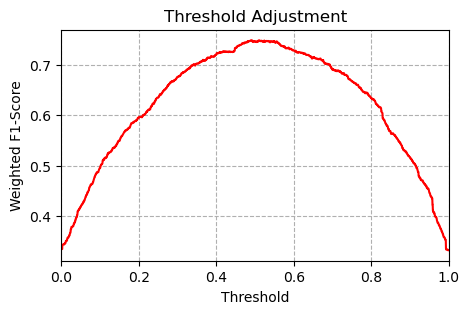

In [22]:

plt.figure(figsize=(5, 3))
plt.rcParams.update({'font.size': 10})
plt.plot(thresholds, weighted_f1_scores, color='r')
plt.title('Threshold Adjustment')
plt.xlabel('Threshold')
plt.ylabel('Weighted F1-Score')
plt.xlim(0,1)
plt.grid(True, linestyle='--')

plt.show()

**Verdict**: The obtained threshold value is very close 0.5, indicating that it may not significantly improve the *weighted F1-score* for the model trained with the current dataset.

### 9. Model evaluation using the test set
We finally evaluate the trained model performance employing the test set. We consider logistic regression (LR) models with the following hyperparameter configurations:
 - LR-1: Hyperparameters set to default values.
 - LR-2: Regularization parameter (C) is optimised.
 - LR-3: Regularization parameter (C) and threshold value are optimised.

In [23]:
#LR-1
y_test_pred_LR1 = model_LR.predict(X_test_tfidf)
report_LR1 = classification_report(y_test, y_test_pred_LR1, output_dict=True)

#LR-2
y_test_pred_LR2 = model_LR_final.predict(X_test_tfidf)
report_LR2 = classification_report(y_test, y_test_pred_LR2, output_dict=True)

#LR-3
y_test_probs_LR3 = model_LR_final.predict_proba(X_test_tfidf)[:, 1]
y_test_pred_LR3 = (y_test_probs_LR3 >= optimal_threshold).astype('int8')
report_LR3 = classification_report(y_test, y_test_pred_LR3, output_dict=True)

# Construct the classification reports
classification_reports_LR =  {  'LR-1': report_LR1,
                                'LR-2': report_LR2,
                                'LR-3': report_LR3
                             }

model_eval_report_LR = get_model_eval_report(classification_reports_LR)
model_eval_report_LR

,Metric,LR-1,LR-2,LR-3
0,Accuracy,0.747,0.756,0.756
1,Precision,0.748,0.756,0.756
2,Recall,0.747,0.756,0.756
3,F1-Score,0.747,0.756,0.756


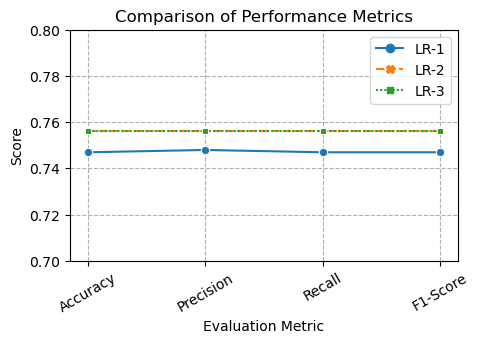

In [24]:
plot_model_eval_report(model_eval_report_LR, [0.7, 0.8])

**Verdict**: Evaluation of the trained models is conducted using the test set. An accuracy of ~75% is achieved. The tuning of hyperparameters, such as regularization strength and adjustment of the threshold value, have a negligible impact on the model performance.

## Summary
For this project, we used machine learning classification models from the Scikit-Learn library to effectively conduct Twitter Sentiment Analysis. This model categorises the general sentiment of tweets as either positive or negative. The basic steps we followed are summarized below.
- **EDA and data preprocessing**: The data is cleaned, tokenised, and normalised.
- **Feature extraction**: The data is split into training, cross-validation, and test sets, and vectorized into numerical features using TF-IDF.
- **Model selection, training and evaluation**: Classification models are selected, trained, and evaluated using metrics such as accuracy, precision, recall, and F1-score.
- **Hyperparameter tuning**: The hyperparameters are chosen corresponding to the best *weighted F1 score* from the grid search employing cross-validation.
- **Threshold adjustment**: The optimal threshold are determined using cross-validation to maximize the *weighted F1 score*.
- **Training and evaluation of final model**: The final model is trained on the entire training set using the best hyperparameters and optimal threshold value. It is then evaluated on the test set using performance metrics.